NB: run `unpack_maalfrid.sh` before running this notebook!

In [3]:
# builds datastructure of translation pairs

pairs = {
    "en-nb": {"en": [], "nb": []},
    "en-nn": {"en": [], "nn": []},
    "nb-nn": {"nb": [], "nn": []}
}

import os
from translate.storage.tmx import tmxfile

for root, dirs, filenames in os.walk("maalfrid"):
    if "-" in root: # in a subfolder with tmx pair files
        folder = root.split("/")[1]
        sourcelang, targetlang = folder.split("-")
        
        
        for filename in filenames:
            with open(root + "/"+ filename, "rb") as f:
                tmx_file = tmxfile(f, sourcelang, targetlang)
            
            for node in tmx_file.unit_iter():
                pairs[folder][sourcelang].append(node.source)
                pairs[folder][targetlang].append(node.target)

In [4]:
#copied from https://tfhub.dev/google/LaBSE/2

import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text as text  # Needed for loading universal-sentence-encoder-cmlm/multilingual-preprocess
import numpy as np

2023-10-26 14:12:31.852436: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-26 14:12:31.883214: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-26 14:12:31.883749: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-26 14:12:33.308390: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
# import preprocessor and LaBSE model
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/LaBSE/2")

2023-10-26 14:12:34.952652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-10-26 14:12:34.953160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-10-26 14:12:34.953277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-10-26 14:12:34.953723: I tensorflow/core/

2023-10-26 14:12:39.195603: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1539542016 exceeds 10% of free system memory.


In [6]:
%%time
from scipy.spatial.distance import cityblock
numberofsentencepairs = 9

for pair in pairs:

    sourcelang, targetlang = pairs[pair].keys()

    sourcesentences = pairs[pair][sourcelang][:numberofsentencepairs]
    targetsentences = pairs[pair][targetlang][:numberofsentencepairs]
    source_embeds = encoder(preprocessor(sourcesentences))["default"]
    target_embeds = encoder(preprocessor(targetsentences))["default"]

    euclideandistances = []    
    manhattandistances = []
    for i in range(0, len(source_embeds)):
        manhattandistances.append(cityblock(source_embeds[i], target_embeds[i]))
        euclideandistances.append(np.linalg.norm(source_embeds[i] - target_embeds[i]))
    
    
    print("Average manhattan distance for " + pair + ":")
    print(sum(manhattandistances)/len(manhattandistances))
    print("Average euclidean distance for " + pair + ":")
    print(sum(euclideandistances)/len(euclideandistances))
    indexworst = euclideandistances.index(max(euclideandistances))
    indexbest = euclideandistances.index(min(euclideandistances))
    break

    #print("Most distant sentence pair with distance of " + str(euclideandistances[indexworst]) + ":")
    #print(sourcesentences[indexworst], "<->", targetsentences[indexworst])
    #print("Closest sentence pair with distance of " + str(euclideandistances[indexbest]) + ":")
    #print(sourcesentences[indexbest], "<->", targetsentences[indexbest])

    print()

Average manhattan distance for en-nb:
149.29032558865018
Average euclidean distance for en-nb:
6.699094401465522
CPU times: user 14.6 s, sys: 330 ms, total: 14.9 s
Wall time: 3.37 s


In [24]:
%%time

from scipy.spatial.distance import cityblock
numberofsentencepairs = 30

iterations = 1

for pair in pairs:
    if pair != "en-nb": 
        continue
    print(pair)
    sourcelang, targetlang = pairs[pair].keys()
    avgsman = []
    avgseuc = []

    for it in range(0, iterations):
        start = numberofsentencepairs*it
        end = numberofsentencepairs*(it+1) - 1
        
        start += 2000
        end += 2000
        print(start, end)
        sourcesentences = pairs[pair][sourcelang][start:end]
        targetsentences = pairs[pair][targetlang][start:end]
        print(sourcesentences[0])
        print(targetsentences[0])

        source_embeds = encoder(preprocessor(sourcesentences))["default"]
        target_embeds = encoder(preprocessor(targetsentences))["default"]

        euclideandistances = []    
        manhattandistances = []
        for i in range(0, len(source_embeds)):
            manhattandistances.append(cityblock(source_embeds[i], target_embeds[i]))
            euclideandistances.append(np.linalg.norm(source_embeds[i] - target_embeds[i]))
        
        avgsman.append(sum(manhattandistances)/len(manhattandistances))
        avgseuc.append(sum(euclideandistances)/len(euclideandistances))
        
        rankeddistances = []
        for i in range(0, len(euclideandistances)):
            rankeddistances.append({"index": i, 
                                    "distance": manhattandistances[i], 
                                    "sentence_source": sourcesentences[i], 
                                    "sentence_target": targetsentences[i]
                                   })
        sorted_distances = sorted(rankeddistances[:30], key=lambda x: x['distance'])

        for e in sorted_distances:
            print("Distance:", e["distance"])
            print(e["sentence_source"])
            print(e["sentence_target"])
            print()
        
        
    print(avgsman)
    print("Average manhattan distance for " + pair + ":")
    print(sum(avgsman)/len(avgsman))
    print("Average euclidean distance for " + pair + ":")
    print(sum(avgseuc)/len(avgseuc))
    
    #indexworst = euclideandistances.index(max(euclideandistances))
    #indexbest = euclideandistances.index(min(euclideandistances))

    #print("Most distant sentence pair with distance of " + str(euclideandistances[indexworst]) + ":")
    #print(sourcesentences[indexworst], " <-> ", targetsentences[indexworst])
    #print("Closest sentence pair with distance of " + str(euclideandistances[indexbest]) + ":")
    #print(sourcesentences[indexbest], " <-> ", targetsentences[indexbest])

    print()

en-nb
2000 2029
Changes in sea ice and its influence on heat transfer between ocean and atmosphere, heat transport in the atmosphere, cloud cover and water vapour that influence long-wave radiation, soot on snow and higher concentrations of soot aerosols in the atmosphere: all these are fundamental conditions for how temperatures evolve.
Endringer i havisen og dennes påvirkning av varmetransporten mellom havet og atmosfæren, varmetransport i havet, varmetransport i atmosfæren, skydekke og vanndamp som påvirker langbølgestrålingen, sot på snø og høyere konsentrasjoner av sot aerosoler i atmosfæren er alle grunnleggende forhold for temperaturutviklingen.
Distance: 110.38599
Average sea level increased by about 0.19 m over the period 1901-2010.
Gjennomsnittlig havnivå har økt med omtrent 0,19 meter over perioden 1901–2010.

Distance: 137.88217
, Franz Josef Land and Svalbard.
, Frans Josefs Land og ved Svalbard.

Distance: 138.39798
Blue whales give birth in the winter months, following a

In [32]:
nb = "Siden 1958, målinger med sonar har det vært gjort sporadiske ved hjelp av ubåter som måler isen fra undersiden, og fra 1990-tallet, fra faste installasjoner"
en = "After 1958, measurements using sonar have been taken sporadically from submarines, and as of the 1990s, also from permanent installations."
#nb = "Siden 1958 har det vært gjort sporadiske målinger med sonar, som måler isen fra undersiden ved hjelp av ubåt og fra 1990-tallet fra faste installasjoner."

en_embed = encoder(preprocessor([en]))["default"][0]
nb_embed = encoder(preprocessor([nb]))["default"][0]

print("en-nb", cityblock(en_embed, nb_embed))

en-nb 137.7324


All samples are from adult males and these extreme differences were also found in previous surveys (from 2002-2004) and it was assumed that this was due to some of the specimens having seals in their diet instead of the normal clams.
Alle prøvene er fra voksne hanner og disse ekstreme forskjellene er funnet også i tidligere undersøkelser (fra 2002–2004) og en antar da at dette skyldtes at enkelte av hvalrossene hadde sel i dietten i stedet for det normale som er muslinger.


/home/jon/Projects/forprosjekt_master/venv/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


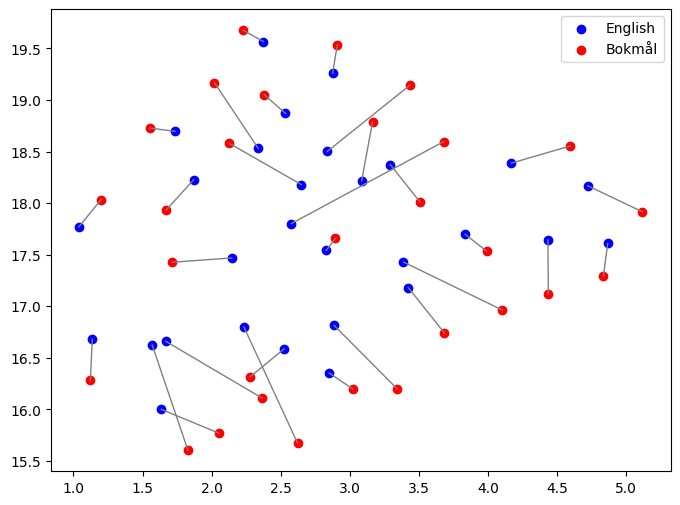

In [23]:
import umap
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
print(sourcesentences[2])
print(targetsentences[2])
source_embeds_vis = source_embeds[:30]
target_embeds_vis = target_embeds[:30]

# Convert and flatten tensors from the first set
data_set1 = np.array([tf.reshape(tensor, (-1,)).numpy() for tensor in source_embeds_vis])
labels_set1 = np.zeros(len(source_embeds_vis))

# Convert and flatten tensors from the second set
data_set2 = np.array([tf.reshape(tensor, (-1,)).numpy() for tensor in target_embeds_vis])
labels_set2 = np.ones(len(target_embeds_vis))


data = np.concatenate((data_set1, data_set2), axis=0)
labels = np.concatenate((labels_set1, labels_set2), axis=0)

# Apply UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(data)

# Visualize the Result
plt.figure(figsize=(8, 6))

# Scatter plot for Set 1
scatter_set1 = plt.scatter(embedding[labels == 0, 0], embedding[labels == 0, 1], label='Set 1', c='blue')

# Scatter plot for Set 2
scatter_set2 = plt.scatter(embedding[labels == 1, 0], embedding[labels == 1, 1], label='Set 2', c='red')

# Add lines connecting corresponding points
for i in range(len(source_embeds_vis)):
    line = Line2D([embedding[i, 0], embedding[i + len(source_embeds_vis), 0]],
                  [embedding[i, 1], embedding[i + len(source_embeds_vis), 1]],
                  linewidth=1, color='gray', alpha=1)
    plt.gca().add_line(line)

#plt.title('UMAP Visualization with Connections')
plt.legend(handles=[scatter_set1, scatter_set2], labels=['English', 'Bokmål'])
plt.show()

In [10]:
num = 51
print(pairs["en-nn"]["en"][num])
print(pairs["en-nn"]["nn"][num])


EMS from analyses of variance (LS) to estimate variances (g and r).
* EMS frå variansanalyse (LS) til å estimera variansar (g og r).
